# Interpretable ML over an Extended Version of  the French Royalty KG

This an example on how **InterpretME** can be used to interpret the prediction and trace back a particular target entity. The KG of the *French Royalty Benchmark* is a fully curated subset of DBpedia; for each person we added the class `dbo:Person` as well as different properties like the number of children or predecessors, and further triple related counts. Here, the predictive task is a binary classification to predict whether a person has a spouse. The statistics of the *French Royalty KG* are presented in the following:

| #triples | #entities | #predicates | #objects | #triples / #entities |
| :-: | :-: | :-: | :-: | :-: |
| 31,599 | 3,439 | 133 | 4,390 | 9.18 |

## Let's Start with Essentials for this Tutorial Notebook

In [1]:
pip install InterpretME

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

**Note:** You may need to restart the kernel to use the updated packages!

The mechanism of InterpretME is as follows:<br>
<ol>
  <li>SHACL validation</li>
  <li>Data preprocessing</li>
  <li>Training of the predictive model</li>
  <li>Understanding the results of interpretability models (e.g., LIME)</li>
  <li>Semantify collected metadata</li>
  <li>Uploading semantified metadata into Virtuoso</li>
  <li>Querying the InterpretME KG and input KG to trace back all properties of a particular entity</li>
</ol>

**Note**: If you don't have Docker (and docker-compose) installed. Please, follow the instructions according to configuration of your machine.

`Linux`:
	https://docs.docker.com/desktop/install/linux-install/<br>
`Windows`:
	https://docs.docker.com/docker-for-windows/install/<br>
`Mac`:
	https://docs.docker.com/docker-for-mac/install/


To get started with the **KG**, you need to start the containers:

In [3]:
!docker-compose up -d

interpretme is up-to-date
frenchroyalty is up-to-date
interpretmekg is up-to-date


Importing required modules from **InterpretME** library:

* `pipeline()`: Run the predictive tasks and interpretation tools (e.g., LIME).
* `plots.sampling()`: Generates plot of the target class distribution.
* `plots.feature_importance()`: Creates bar plot of important features.
* `plots.decision_trees()`: Generates trees of predictions made by predictive model.
* `plots.constraints_decision_trees()`: Trees are incorporated with SHACL validation results.
* `federated()`: Query the *InterpretME KG* and the input KG to trace back all properties of a target entity.


In [4]:
from InterpretME import *

shaclAPI logger assigned!


**InterpretME** takes a JSON file as input (i.e., *URL of the input KG, features’ definition, target definition, SHACL constraints, sampling strategy, class definition*); a `SPARQL query` is generated based on the feature definition given by the user and the query is used to retrieve the application domain data from the input KG.

Given the input **KG** that integrates the features’ and class target definitions about French Royalty; and their SHACL constraints. The features’ definition is classified into independent and dependent variables; later used in the predictive modeling pipeline. The features can be defined in the following format:

```JSON
{
  "Endpoint": "https://localhost:8892/sparql",
  "Index_var": "Person",
  "Independent_variable": {
    "x": "?x a <http://dbpedia.org/ontology/Person>.\n ",
    "gender": "Optional { ?x <http://dbpedia.org/ontology/gender> ?gender }"},
  "Dependent_variable": {
    "HasSpouse": "{ SELECT ?x, ((?partners > 0) AS ?HasSpouse) WHERE { ?x <http://dbpedia.org/ontology/numSpouses> ?partners . }} \n"}
  "Constraints": [{
    "name": "C1",
    "inverted": false,
    "shape_schema_dir": "example/shapes/french_royalty/spouse/rule1",
    "target_shape": "Spouse"
  }],
  "classes": {
    "NoSpouse": "0",
    "HasSpouse": "1"
  },
  "sampling_strategy": "undersampling",
  "number_important_features": 5,
  "cross_validation_folds": 5,
  "test_split": 0.3,
  "model": "Random Forest"
}
```

The purpose of `pipeline()` is to assemble several components of **InterpretME** that can be evaluated together while setting different parameters. First, it starts with evaluating the SHACL constraints over the nodes of input KGs and generates a validation report per target entity. This report shows if a particular entity validates/invalidate the constraints defined by the user. 

The *data preprocessing* step includes transforming the data extracted from the input KG into a form that can be used to train the predictive pipeline. To avoid imbalance, the sampling strategy defined by the user is deployed. To handle categorical values from data, one-hot encoding is utilized.

The *predictive model building* step can be achieved based on user preferences. Given the French Royalty preprocessed data, automated tools are utilized for models (e.g., *Ensemble Learning*) and to optimize the hyperparameter selection for predictive tasks. 

Here, the automated predictive model can perform stratified shuffle split cross-validation with *Random Forest*, *Adaboost Classifier*, or *Gradient Boosting Classifier* and identify the relevant features; they are used to train a *Decision Tree* classifier to predict and visualize the outcomes.

In this step, the metadata collected are the features' definition, trained model, hyperparameters, predictions, precision, recall, classification report, as well as confusion matrix files generated from the trained predictive model. The metadata are later used in the creation of InterpretME KG.

The current version of InterpretME uses *LIME* [1] to have local interpretations of the target entities.
*LIME* also identifies the top-10 relevant features for the target entity and assigns weights. The results allow the user to understand the quality of the predictive model.

The RDF mapping language (RML) is used to define mappings for the metadata collected from the predictive pipeline in order to integrate them into the **InterpretME KG**.
The RML mappings are used by the SDM-RDFizer [2], an efficient RML engine for creating knowledge graphs, to semantify the metadata. InterpretME relies on **FAIR** principles for defining the *InterpretME ontology* by extending *ML schema*; it is available on [VoCol](http://ontology.tib.eu/InterpretME/).

The generated RDF data will be uploaded to an instance of *Virtuoso*.

In [5]:
results = pipeline(path_config='./example.json', lime_results='./LIME',
                   server_url='http://localhost:8891/', username='dba', password='dba')

1661956528986
SELECT ?x ?gender ?childs ?predecessors ?preds ?objects ?subjects ?HasSpouse  WHERE { ?x a <http://dbpedia.org/ontology/Person>. 
 Optional { ?x <http://dbpedia.org/ontology/gender> ?gender } .
 ?x <http://dbpedia.org/ontology/numChilds> ?childs . 
 ?x <http://dbpedia.org/ontology/numPredecessors> ?predecessors . 
?x <http://dbpedia.org/ontology/numPreds> ?preds .
?x <http://dbpedia.org/ontology/numObjects> ?objects . 
?x <http://dbpedia.org/ontology/numSubjects> ?subjects . 
{ SELECT ?x, ((?partners > 0) AS ?HasSpouse) WHERE { ?x <http://dbpedia.org/ontology/numSpouses> ?partners . }} 
}
Number of unique nodes: 2212
Skip adding filter clause because no checker instance is provided.
Validating shapes/french_royalty/spouse/rule10 for targets ['Spouse']
Total execution time:  49  ms
Number of validated targets: shapes/french_royalty/spouse/rule10_Spouse    202
dtype: int64
Skip adding filter clause because no checker instance is provided.
Validating shapes/french_royalty/sp

  0%|          | 0/497 [00:00<?, ?it/s]

#########################################################################################
****************** Classification report saved in output folder *************************
#########################################################################################
        classes  precision    recall  f1-score   support         run_id
0             0   0.994764  0.769231  0.867580  247.0000  1661956528986
1             1   0.813725  0.996000  0.895683  250.0000  1661956528986
2      accuracy   0.883300  0.883300  0.883300    0.8833  1661956528986
3     macro avg   0.904245  0.882615  0.881632  497.0000  1661956528986
4  weighted avg   0.903699  0.883300  0.881717  497.0000  1661956528986
Identified 1988 unique seed nodes!
In comparison to the BaseDataset this makes a total of 224 unneeded seed nodes!
#####################################################################
******* Semantifying traced metadata from predictive pipeline *******
###########################################

### Exploration of Predictive Results via Decision Trees

To understand the trained predictive model's decisions, an automated model is deployed and a visualization of the prediction is performed via *Decision Trees*. Here, the user can also visualize SHACL constraints with decision trees which shows entities violating the constraints/validating constraints. 

The user can provide the path where to store the output plots, like sampling strategy (target class distribution), feature importance, and decision trees.

#### Sampling

Saving sampling strategy plot to ./output//sampling_1661956528986.png


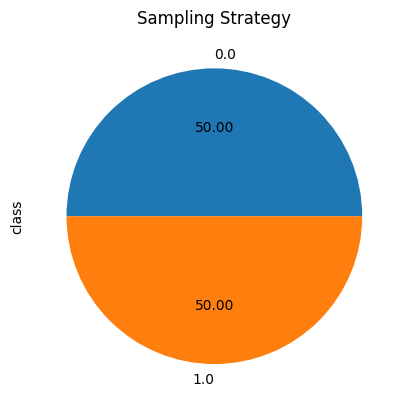

In [6]:
plots.sampling(results=results, path='./output/')

#### Feature Importance

Saving feature importance plot to ./output//Feature Importance_1661956528986.png


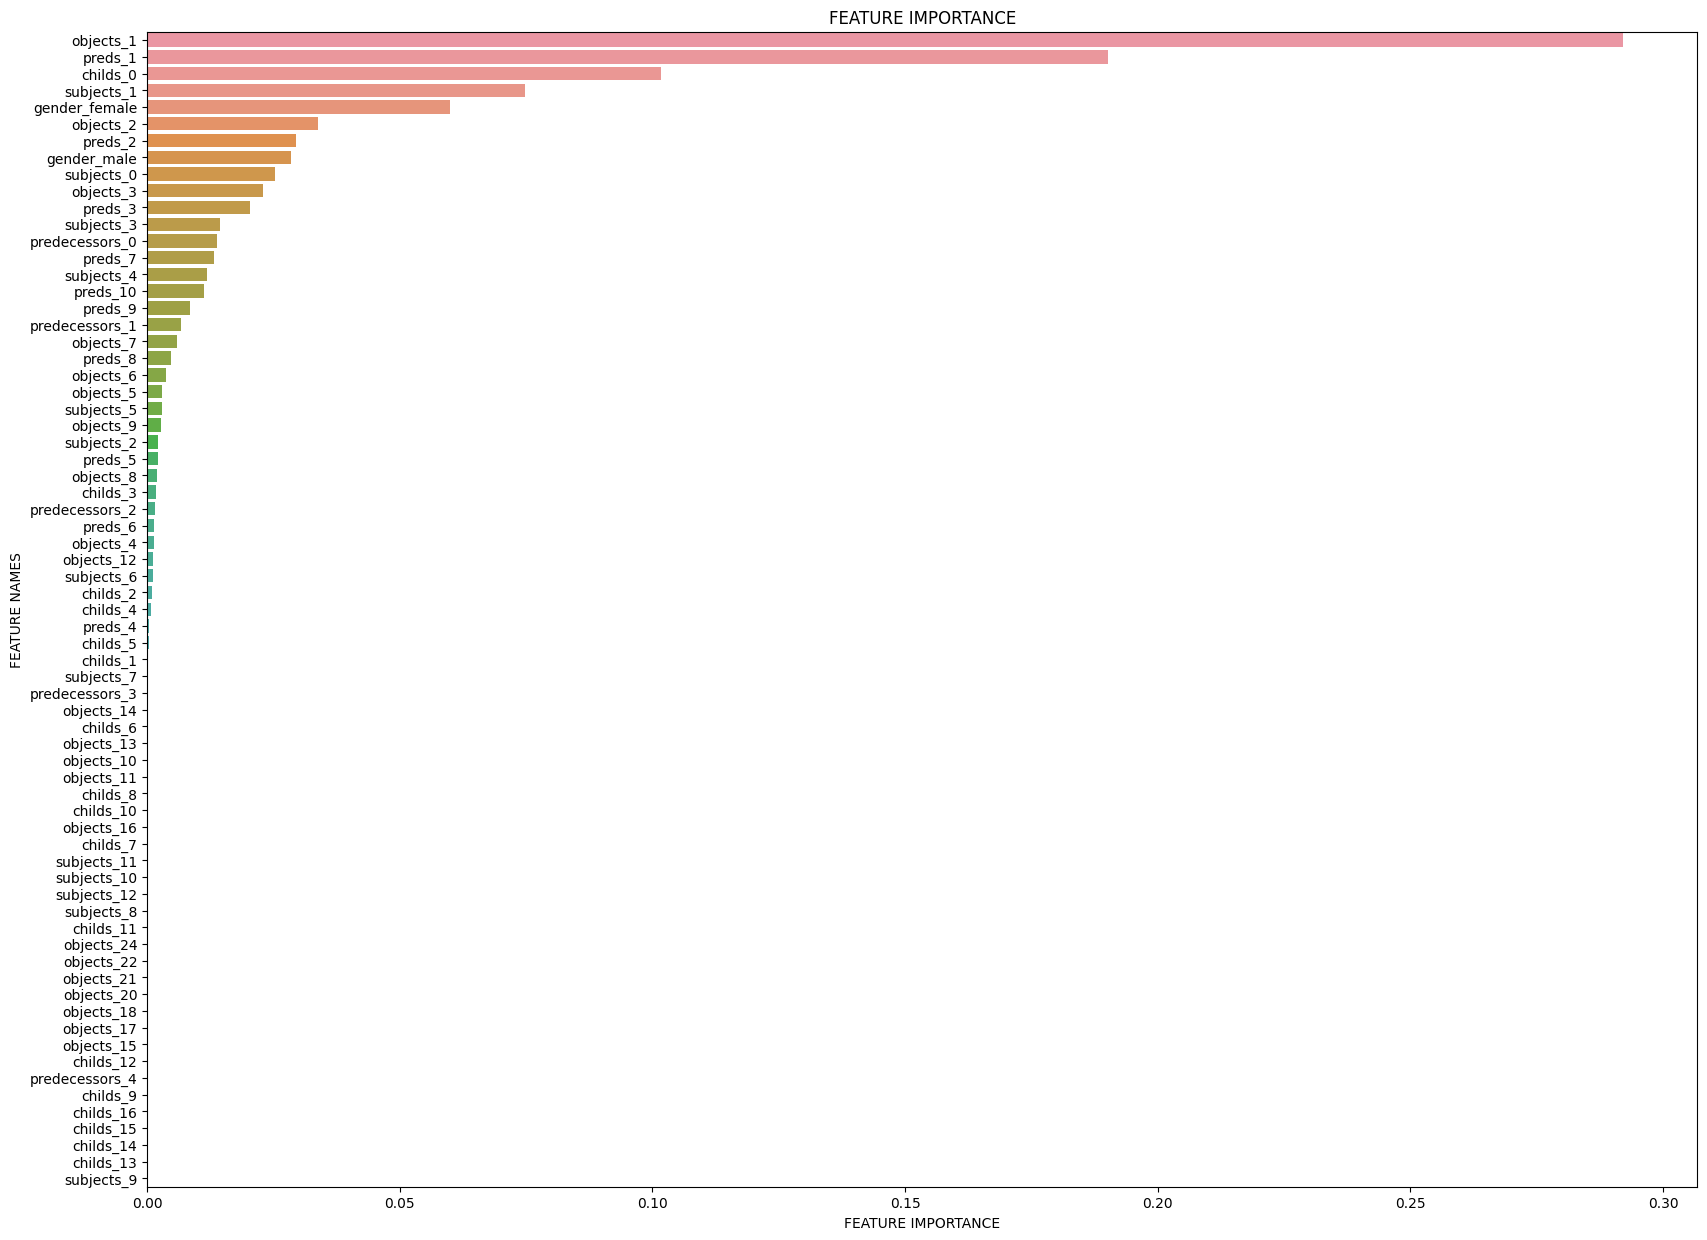

In [7]:
plots.feature_importance(results=results, path='./output/')

#### Decision Trees

In [8]:
plots.decision_trees(results=results, path='./output/')

Saving decision trees to ./output//Decision_trees_1661956528986.svg


#### Decision Trees with Constraint Validation

In [9]:
plots.constraints_decision_trees(results=results, path='./output/', constraint_num=[3])

Saving constraints decision trees to ./output/
Directly joining with the sample to node mapping!
Calculating node samples!
Using 1 worker(s)!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.73it/s]


Directly joining with the sample to node mapping!
Reusing Node_samples!
Using 1 worker(s)!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.89it/s]


Directly joining with the sample to node mapping!
Reusing Node_samples!
Using 1 worker(s)!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 10.66it/s]


Directly joining with the sample to node mapping!
Directly joining with the sample to node mapping!
Reusing Node_samples!
Using 1 worker(s)!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.09it/s]


Directly joining with the sample to node mapping!
Reusing Node_samples!
Using 1 worker(s)!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.04it/s]


Directly joining with the sample to node mapping!
Reusing Node_samples!
Using 1 worker(s)!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.02it/s]


Directly joining with the sample to node mapping!
Reusing Node_samples!
Using 1 worker(s)!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  9.05it/s]


Directly joining with the sample to node mapping!
Reusing Node_samples!
Using 1 worker(s)!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.36it/s]


Directly joining with the sample to node mapping!
Reusing Node_samples!
Using 1 worker(s)!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.59it/s]


Directly joining with the sample to node mapping!
Reusing Node_samples!
Using 1 worker(s)!


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:01<00:00,  8.73it/s]


### Federated Query Processing

After uploading the semantified results to the InterpretME KG, [DeTrusty](https://github.com/SDM-TIB/DeTrusty) [3] is utilized to answer the user's questions via SPARQL queries over **both** the input KG and the *InterpretME KG*. In `./queries/french_royalty` you can find templates for answering the following questions:
1. Which is the target entity interpreted by LIME?
2. How does ***feature*** contribute to the classification of this entity in class ***class***
3. Which other features are relevant for this classification?
4. Does this target entity satisfy the domain integrity constraints?
5. What are the main characteristics of the target entity?

In [10]:
from InterpretME.federated_query_engine import configuration, federated

In [11]:
input_query = """
SELECT DISTINCT ?sourceEntity ?InterpretableTool ?feature ?value ?targetClass ?probability
WHERE {
    SERVICE <http://localhost:8891/sparql> {
        FILTER( ?LIMEentity=<http://interpretme.org/entity/Louis_XIV> )
        ?entity a <http://interpretme.org/vocab/TargetEntity> .
        ?entity <http://www.w3.org/2002/07/owl#sameAs> ?sourceEntity .
        ?entity <http://interpretme.org/vocab/hasEntity> ?LIMEentity .
        ?entity <http://interpretme.org/vocab/hasInterpretedFeature> ?interpretedFeature .
        ?interpretedFeature <http://interpretme.org/vocab/hasFeatureWeight> ?featureWeight .
        ?interpretedFeature <http://www.w3.org/ns/prov#hasGeneratedBy> ?InterpretableTool .
        ?entity <http://interpretme.org/vocab/hasEntityClassProbability> ?classProb .
        ?classProb <http://interpretme.org/vocab/hasPredictionProbability> ?probability .
        ?classProb <http://interpretme.org/vocab/hasClass> ?targetClass .
        ?featureWeight <http://interpretme.org/vocab/hasFeature> ?feature .
        ?featureWeight <http://interpretme.org/vocab/hasWeight> ?value .
    }
}
"""


In [12]:
interpretme_endpoint = 'http://localhost:8891/sparql'
input_endpoint = 'http://localhost:8892/sparql'

In [13]:
config = configuration(interpretme_endpoint, input_endpoint)
query_answer = federated(input_query, config)

2022-08-31 16:40:47,524 - rdfmts - INFO - Finding inter-links between: http://localhost:8891/sparql and http://localhost:8892/sparql
2022-08-31 16:40:47,525 - rdfmts - INFO - ==============================//=========//===============================
2022-08-31 16:40:47,615 - rdfmts - INFO - Finding inter-links between: http://localhost:8892/sparql and http://localhost:8891/sparql
2022-08-31 16:40:47,616 - rdfmts - INFO - ==============================//=========//===============================
2022-08-31 16:40:56,154 - rdfmts - INFO - ----- DONE in 9.32003116607666 seconds!-----


#####################################################################
********************* Federated Query Engine ************************
#####################################################################
{'head': {'vars': ['sourceEntity', 'InterpretableTool', 'feature', 'value', 'targetClass', 'probability']}, 'cardinality': 10, 'results': {'bindings': [{'sourceEntity': {'value': 'http://dbpedia.org/resource/Louis_XIV', 'type': 'uri'}, 'InterpretableTool': {'value': 'http://interpretme.org/entity/LIME', 'type': 'uri'}, 'feature': {'value': 'http://interpretme.org/entity/objects_1%20%3C%3D%200.00', 'type': 'uri'}, 'value': {'value': '0.748868', 'type': 'literal'}, 'targetClass': {'value': 'http://interpretme.org/entity/0', 'type': 'uri'}, 'probability': {'value': '0.0653595', 'type': 'literal'}, '__meta__': {'is_verified': True}}, {'sourceEntity': {'value': 'http://dbpedia.org/resource/Louis_XIV', 'type': 'uri'}, 'InterpretableTool': {'value': 'http://interpretme.org/entity/LIME',

In [14]:
query_answer

{'head': {'vars': ['sourceEntity',
   'InterpretableTool',
   'feature',
   'value',
   'targetClass',
   'probability']},
 'cardinality': 10,
 'results': {'bindings': [{'sourceEntity': {'value': 'http://dbpedia.org/resource/Louis_XIV',
     'type': 'uri'},
    'InterpretableTool': {'value': 'http://interpretme.org/entity/LIME',
     'type': 'uri'},
    'feature': {'value': 'http://interpretme.org/entity/objects_1%20%3C%3D%200.00',
     'type': 'uri'},
    'value': {'value': '0.748868', 'type': 'literal'},
    'targetClass': {'value': 'http://interpretme.org/entity/0', 'type': 'uri'},
    'probability': {'value': '0.0653595', 'type': 'literal'},
    '__meta__': {'is_verified': True}},
   {'sourceEntity': {'value': 'http://dbpedia.org/resource/Louis_XIV',
     'type': 'uri'},
    'InterpretableTool': {'value': 'http://interpretme.org/entity/LIME',
     'type': 'uri'},
    'feature': {'value': 'http://interpretme.org/entity/objects_1%20%3C%3D%200.00',
     'type': 'uri'},
    'value': {'

------------
**References**

[1] Marco Ribeiro, Sameer Singh, and Carlos Guestrin. "Why Should I Trust You?": Explaining the Predictions of Any Classifier. In: Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (KDD '16). ACM. 2016. DOI: [10.1145/2939672.2939778](https://dl.acm.org/doi/10.1145/2939672.2939778).

[2] E. Iglesias, S. Jozashoori, D. Chaves-Fraga, D. Collarana and M.-E. Vidal. SDM-RDFizer: An RML Interpreter for the Efficient Creation of RDF Knowledge Graphs. In: CIKM ’20:Proceedings of the 29th ACM International Conference on Information & Knowledge Management, ACM, New York, NY,USA, 2020. DOI: [10.1145/3340531.3412881](https://dl.acm.org/doi/pdf/10.1145/3340531.3412881).

[3] P.D. Rohde. DeTrusty v0.6.1, August 2022. DOI: [10.5281/zenodo.6998001](https://doi.org/10.5281/zenodo.6998001).